# A Simple Neural Network Handwritten Digit Classifer

#### Brian Chen | 2019


In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### Imports

In [0]:
import os
# import numpy as np
from matplotlib import pyplot
from scipy import optimize #Optimization w/ library, will compare speed with my gradient descent later
from scipy.io import loadmat
# import cupy as np 
import numpy as np
%matplotlib inline

## Utility Functions

In [0]:
def sigmoid(z):
    #returns sigmoid function of z given z
    return (1.0/(1.0+np.exp(-z)))

In [0]:
def sigmoidGradient(z):
  return((1)/(1+np.exp(-z)))*(1-((1)/(1+np.exp(-z))))

In [0]:
def predict(Theta_1, Theta_2, X):
#predicts label of input X given weights Theta_1, Theta_2
    m = X.shape[0] #number of input rows
    num_labels = Theta_2.shape[0] # of output rows
    p = np.zeros(m) #prediction

    #forward propogate X through weights

    h1 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), X], axis=1), Theta_1.T))
    h2 = sigmoid(np.dot(np.concatenate([np.ones((m, 1)), h1], axis=1), Theta_2.T))

    p = np.argmax(h2, axis=1)

    return p
    

In [0]:
def displayData(X, title, example_width = None, figsize = (10,10)):
    #"stolen" from Andrew Ng's Machine Learning Ex.4
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.around(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    pyplot.title(title, color = "white")
    

    for i, ax in enumerate(ax_array):
        # Display Image
        h = ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                      cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


In [0]:
def rand_weight(num_in, num_out, weight_range):
    #returns a random matrix of weights of the appropriate size given range
    return(((np.random.rand(num_out, 1+num_in))*weight_range*2) - weight_range)

### Cost Function

In [0]:
def cost(initial_weights_vector, input_size, hidden_layer_size, labels, X, Y, lambda_):
    #reshape weight_vector
    
    Theta_1 = np.reshape(initial_weights_vector[:hidden_layer_size * (input_size + 1)],
                        (hidden_layer_size, (input_size + 1)))

    Theta_2 = np.reshape(initial_weights_vector[(hidden_layer_size * (input_size + 1)):],
                        (labels, (hidden_layer_size + 1)))

    m = Y.size
    
    temp1 = Theta_1
    temp2 = Theta_2

    #forwards prop
    
    a1 = np.concatenate([np.ones((m,1)), X], axis = 1)

    a2 = np.dot(a1, np.transpose(Theta_1))
    a2 = sigmoid(a2)
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis = 1)
                         
    a3 = np.dot(a2, np.transpose(Theta_2))
    a3 = sigmoid(a3)
                         
    #calcuate cost
    ymat = Y.reshape(-1) 
    ymat = np.eye(labels)[ymat]

    J = (1/m)*np.sum((-ymat* np.log(a3)) - ((1-ymat)*np.log(1-a3)))
    J = J + (lambda_/(2*m))*(np.sum(np.square(temp1[:,1:])) + np.sum(np.square(temp2[:,1:])))

    #backwards prop
    d3 = (a3-ymat)
    d2 = np.dot(d3, (Theta_2[:,1:]))
    d2 = d2* sigmoidGradient(np.dot(a1, np.transpose(Theta_1)))
    
    D1 = np.dot(np.transpose(d2), a1)
    D2 = np.dot(np.transpose(d3), a2)
    
    t1_grad = (1/m)*D1
    t2_grad = (1/m)*D2
    
    #regularize gradients
    
    t1_grad[:,1:] = t1_grad[:,1:] + (lambda_/m)*Theta_1[:,1:]
    t2_grad[:,1:] = t2_grad[:,1:] + (lambda_/m)*Theta_2[:,1:]
    
    grad = np.concatenate([t1_grad.ravel(), t2_grad.ravel()])
    # print("grad shape", grad.shape)
    # print("t1 gradshape", t1_grad.shape)
    # print("t1 shape", Theta_1.shape)
    # print("t2 gradshape", t2_grad.shape)
    # print("t2 shape", Theta_2.shape)
    return J, grad


### Gradient Descent


In [0]:
#gradient descent

def gradientDescent(costfunc, hidden_layer_size, input_size, labels, initial_weights_vector, alpha, iterations):
  Theta_1 = np.reshape(initial_weights_vector[:hidden_layer_size * (input_size + 1)],(hidden_layer_size, (input_size + 1)))
  Theta_2 = np.reshape(initial_weights_vector[(hidden_layer_size * (input_size + 1)):],(labels, (hidden_layer_size + 1)))
  weights = initial_weights_vector
  
  for i in range(iterations):
    J, grad = costfunc(weights)
    print(J, "cost")
    Theta_1_Grad = np.reshape(grad[:hidden_layer_size * (input_size + 1)],(hidden_layer_size, (input_size + 1)))
    Theta_2_Grad = np.reshape(grad[(hidden_layer_size * (input_size + 1)):],(labels, (hidden_layer_size + 1)))
    m = Y.shape[0]

    Theta_1 = Theta_1 - (alpha/m)*Theta_1_Grad
    Theta_2 = Theta_2 - (alpha/m)*Theta_2_Grad

    weights = np.concatenate([Theta_1_Grad.ravel(), Theta_2_Grad.ravel()])

  J, grad = costfunc(weights)
  return weights

#### Init weights

In [0]:
#load data

data = loadmat(os.path.join("/content/drive/My Drive/MLCourse/Data", "digits_data.mat"))
X = data['X']
Y = data['y'].ravel()

# X = np.array(X)
# Y = np.array(X)

#correct for matlab indicies
Y[Y==10] = 0

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
input_size  = 400  # 20x20 Images 
hidden_layer_size = 25   # 25 hidden units
labels = 10          # 0 to 9

m = Y.size

In [0]:
Theta_1_init = rand_weight(input_size, hidden_layer_size, 0.1)
Theta_2_init = rand_weight(hidden_layer_size, labels, 0.1)

initial_weights_vector = np.concatenate([Theta_1_init.ravel(), Theta_2_init.ravel()], axis = 0)

#### Optimize w/ scipy

In [0]:

a= {'maxiter': 100}

lambda_ = 10


costfunc = lambda w: cost(w, input_size, hidden_layer_size, labels, X, Y, lambda_)


res = optimize.minimize(costfunc, initial_weights_vector, jac=True, method='TNC', options=a)

weights = res.x
        
# Obtain Theta1 and Theta2 back from nn_params
Theta_1 = np.reshape(weights[:hidden_layer_size * (input_size + 1)],
                    (hidden_layer_size, (input_size + 1)))

Theta_2 = np.reshape(weights[(hidden_layer_size * (input_size + 1)):],
                    (labels, (hidden_layer_size + 1)))

In [0]:
#@title Gradient descent parameters
#optimize with gradient descent

num_iter = 20000 #@param {type: "number"}
alpha = 0.000001 #@param {type: "number"}
costfunc = lambda w: cost(w, input_size, hidden_layer_size, labels, X, Y, lambda_)

weights = gradientDescent(costfunc, hidden_layer_size, input_size, labels, initial_weights_vector, alpha, num_iter)

Theta_1 = np.reshape(weights[:hidden_layer_size * (input_size + 1)], (hidden_layer_size, (input_size + 1)))

Theta_2 = np.reshape(weights[(hidden_layer_size * (input_size + 1)):], (labels, (hidden_layer_size + 1)))


#### Prediction

In [0]:
pred = predict(Theta_1, Theta_2, X)
print(len(X))
print("Average Accuracy: ",np.mean(pred==Y)*100, "%")


5000
Average Accuracy:  93.22 %


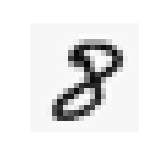

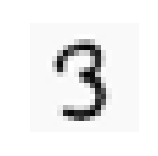

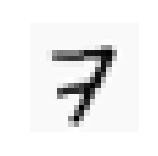

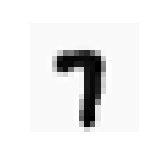

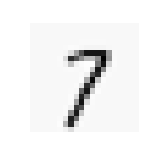

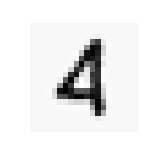

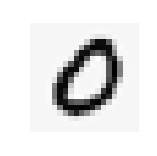

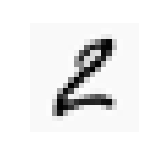

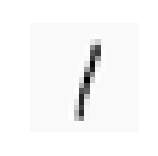

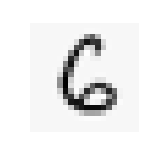

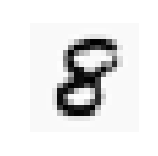

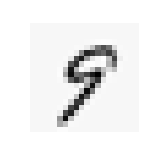

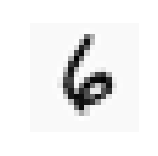

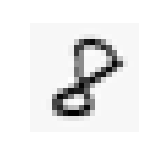

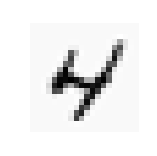

In [0]:
#@title b - (m)istake, (c)orrect | a - # to display
#show an image + predicted value
b = 'c' #@param {type: "string"} 
a = 15 #@param {type: "number"}
if b == "c":
  ind = np.random.permutation(m)[:a] #a list of random indicies X-()
  for i in ind:
    d = "Prediction: " + str(pred[i]) + " Actual: " + str(Y[i]) 
    displayData(X[i,:], d , figsize = (2,2))

elif b == "m":
  for x in range(Y.shape[0]):
    if a == 0:
      break
    else:
      if int(Y[x]) != (pred[x]):
        d = "Prediction: " + str(pred[x]) + " Actual: " + str(Y[x]) 
        displayData(X[x,:],d, figsize = (2,2))
        a=a-1

else:
  print("try again")
